In [57]:
from db_api.connect import session
from db_api import models as d_models

In [58]:
session.query(d_models.Experiment).all()

In [50]:
%matplotlib inline
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from plot import set_font_size

cc = np.concatenate

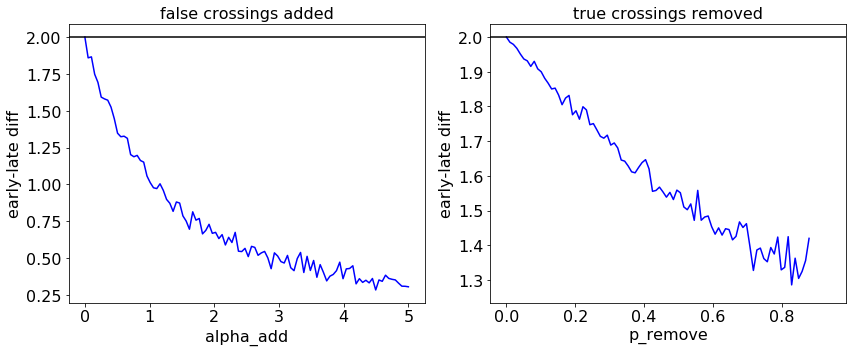

In [54]:
ALPHA = 2.5
MAX_CROSSINGS = 5
MAX_EARLY = 2
Y_EARLY = 3
Y_LATE = 1
N = 1000
ALPHAS_ADD = np.linspace(0, 5, 100)
P_REMOVES = np.linspace(0, 1, 100)

def early_late_diff(trajs):
    """Calculate the early minus late difference for a set of trajectories."""
    ys_early = []
    ys_late = []
    
    for traj in trajs:
        
        # get crossing ordering
        idxs = np.argsort(traj['x'])
        
        # get early vals
        ys_early.extend(list(traj['y'][idxs[:MAX_EARLY]]))
        
        # get late vals
        ys_late.extend(list(traj['y'][idxs[MAX_EARLY:]]))
    
    if (not ys_early) or (not ys_late):
        return np.nan
    
    return np.mean(ys_early) - np.mean(ys_late)
        

# make ideal trajectories
trajs = []

for ctr in range(N):
    # sample number of crossings
    n_crossings = min(np.random.poisson(ALPHA), MAX_CROSSINGS)
    
    # sample crossing times
    x = np.random.rand(n_crossings)
    
    # assign crossing values
    y = Y_LATE * np.ones(len(x))
    y[np.argsort(x)[:MAX_EARLY]] = Y_EARLY
    
    trajs.append({'x': x, 'y': y, 'n': n_crossings})
    
# calculate ideal diff
early_late_diff_ideal = early_late_diff(trajs)

# make trajectories with zero-valued crossings randomly added
early_late_diffs_add = []

for alpha_add in ALPHAS_ADD:
    
    trajs_add = deepcopy(trajs)
    
    for traj in trajs_add:
        n_add = np.random.poisson(alpha_add)
        traj['x'] = cc([traj['x'], np.random.rand(n_add)])
        traj['y'] = cc([traj['y'], np.zeros(n_add)])
        
    early_late_diffs_add.append(early_late_diff(trajs_add))

# make trajectories with crossings randomly removed
early_late_diffs_remove = []

for p_remove in P_REMOVES:
    
    trajs_remove = deepcopy(trajs)
    
    for traj in trajs_remove:
        mask = ~(np.random.rand(traj['n']) < p_remove)
        traj['x'] = traj['x'][mask]
        traj['y'] = traj['y'][mask]
        
    early_late_diffs_remove.append(early_late_diff(trajs_remove))
    
# make figure
fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

# added false crossings
axs[0].plot(ALPHAS_ADD, early_late_diffs_add, color='b')
axs[0].axhline(early_late_diff_ideal, color='k')
axs[0].set_xlabel('alpha_add')
axs[0].set_ylabel('early-late diff')
axs[0].set_title('false crossings added')

# removed true crossings
axs[1].plot(P_REMOVES, early_late_diffs_remove, color='b')
axs[1].axhline(early_late_diff_ideal, color='k')
axs[1].set_xlabel('p_remove')
axs[1].set_ylabel('early-late diff')
axs[1].set_title('true crossings removed')

for ax in axs:
    set_font_size(ax, 16)